### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Initialization of the parameters (w_d0, w_d1...)




In [3]:
# Starting with the initialization of the parameters

w_d0 = 1.4 #Default synaptic weight
w_d1 = 0.18 #Default synaptic weight

alpha = 0.01 #Synaptic plasticity
MI = 0.1 #Extrinsic modulatory input
lr = 0.1 #Learning rate
n_kernels = 40 #Number of hidden neurons


## Create the class for the CPG

In [4]:
# Create the CPG Class

class CPG:
    def __init__(self, w_d0, w_d1, alpha, MI):
        self.w_11 = w_d0 #Fixed synaptic weight (self-connection weights)
        self.w_22 = w_d0 #Fixed synaptic weight (self-connection weights)
        self.w_12 = w_d1 + MI # Modulated synaptic weight (cross-connection weights)
        self.w_21 = -w_d1 - MI # Modulated synaptic weight (cross-connection weights)
        self.alpha = alpha #synaptic plasticity

    def update(self, o_N1, o_N2, S1, S2):
        a1 = self.w_11 * o_N1 + self.w_12 * o_N2 + self.alpha * S1
        a2 = self.w_22 * o_N2 + self.w_21 * o_N1 + self.alpha * S2

        o_N1 = self.tanh(a1)
        o_N2 = self.tanh(a2)

        return o_N1, o_N2

    def tanh(self, x):
        return np.tanh(x)

## Simulation with only CPGs

I am simulating by generating arrays with size = num_steps and print them as graphs


In [5]:
# Simulation parameters
num_steps = 200 #Number of time steps
x = np.arange(num_steps)
S1 = np.ones(num_steps) #np.sin(0.1*x)
S2 = np.ones(num_steps) #np.cos(0.1*x)

# Initialize CPG outputs
o_N1 = 0.2 #0.0
o_N2 = 0.0 #0.0

cpg = CPG(w_d0, w_d1, alpha, MI=MI)

# Lists to store CPG outputs for plotting
output_1_cpg = []
output_2_cpg = []

# Simulation loop
for i in range(num_steps):
    o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
    #print(o_N1, o_N2)
    output_1_cpg.append(o_N1)
    output_2_cpg.append(o_N2)

### Plot

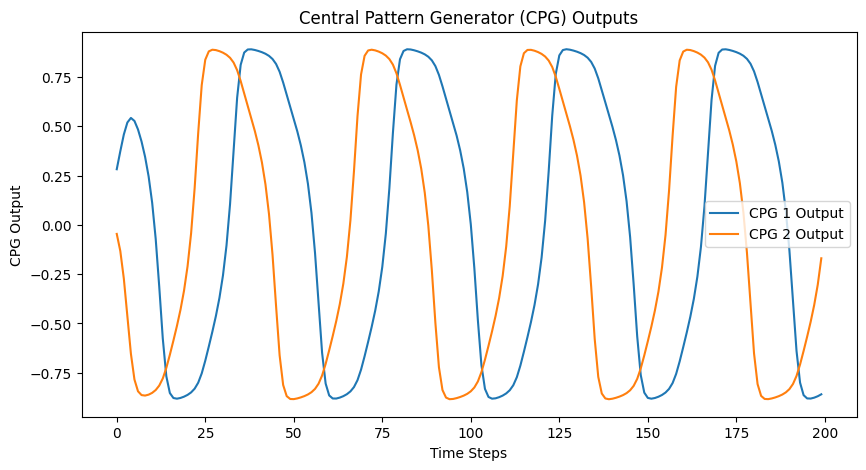

In [6]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, output_1_cpg, label='CPG 1 Output')
plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()

## Create the class for the RBF and add it

In [7]:
class RBF:
    def __init__(self,n_kernels, lr, sigma):
        self.n_kernels = n_kernels
        self.sigma = sigma
        self.lr = lr  # learning rate

    def get_activation(self, cpg_1, cpg_2, mu_1, mu_2):
        '''
        Gaussian activation function, based on the distance between the CPG outputs and the RBF kernels
        '''
        return np.exp(-((cpg_1 - mu_1)**2 + (cpg_2 - mu_2)**2) / (2 * self.sigma**2))

## Simulation with CPGs+RBF

In [8]:
# Simulation parameters
num_steps = 40
x = np.arange(num_steps)
S1 = np.ones(num_steps) #np.sin(0.1*x)
S2 = np.ones(num_steps) #np.cos(0.1*x)

# Initialize CPG outputs
o_N1 = 0.2 #0.0
o_N2 = 0.0 #0.0

# Lists to store CPG outputs for plotting
output_1_cpg = []
output_2_cpg = []

# Initialize RBF parameters (n_kernels=40)
n_kernels = 40
means_kern_pos = np.linspace(0,num_steps-1,n_kernels).astype(int) # Cast to integer values because they are positions
sigma = 0.4 #0.4 #from the article
print(means_kern_pos) 

# Lists to store RBF outputs for plotting
kernels = []
sigma = 0.2

cpg = CPG(w_d0, w_d1, alpha, MI=MI)
rbf = RBF(n_kernels, lr, sigma)

# Simulation loop: CPG
for i in range(num_steps):
    o_N1, o_N2 = cpg.update(o_N1, o_N2, S1[i], S2[i])
    output_1_cpg.append(o_N1)
    output_2_cpg.append(o_N2)

print(len(output_1_cpg))
# Simulation loop: RBF
for j in means_kern_pos:
    kernel = []
    for i in range(num_steps):
        phi = rbf.get_activation(output_1_cpg[i], output_2_cpg[i], output_1_cpg[j], output_2_cpg[j])
        kernel.append(phi)
    kernels.append(kernel)

# Convert the list to a numpy array
kernels = np.array(kernels) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
40


### Plot

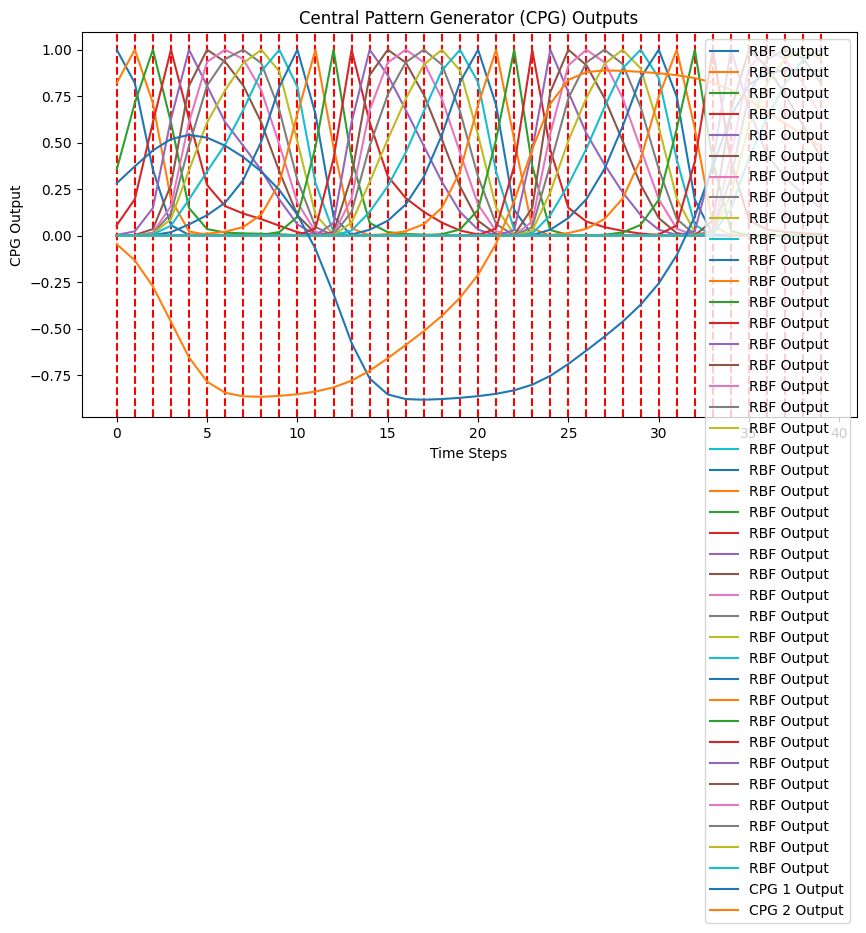

In [9]:
# Plotting
plt.figure(figsize=(10, 5))
for i in range(len(means_kern_pos)):
    plt.axvline(x=means_kern_pos[i], color='r', linestyle='--')
for i in range(n_kernels):
    plt.plot(x, kernels[i], label='RBF Output')
plt.plot(x, output_1_cpg, label='CPG 1 Output')
plt.plot(x, output_2_cpg, label='CPG 2 Output')
plt.xlabel('Time Steps')
plt.ylabel('CPG Output')
plt.title('Central Pattern Generator (CPG) Outputs')
plt.legend()
plt.show()

The output signals from the RBF neurons are linearly combined at four linear output neurons as:
$$
o_{R B F_j}(t)=\sum_{n=1}^N w_{j n} \phi_n(t), j \in 1, \ldots, 4,
$$
$w_{j n}$ represents the weights used to shape and combine the transmitted signals between the RBF hidden and output neurons. 

The first three output neurons are used as three motor neurons $\left(\mathrm{M}_{1, \ldots, 3}\right.)$ for controlling the TC-, CTr-, and FTi-joints and the last output neuron as a forward model neuron FP for predicting foot contact feedback. 

This RBF premotor network structure is the same for all six neural control systems controlling the six legs of the robot. 

The output weights $w_{j n}$ are trained offline using a delta or error-based learning rule as follows:
$$
\Delta \mathrm{w}_{j n}=\eta\left(T_j(t)-\sum_{n=1}^N w_{j n} \phi_n(t)\right), j \in 1, \ldots, 4, n \in 1, \ldots, N .
$$

#  Training the RBF

In [10]:
# Define the target
target = np.linspace(0,100, 40) 
# Initialize the weights
W = np.ones(n_kernels) 

outputs = [] #initialize the output

output = 0

# Calculate the output of the RBF layer
#for j in range(num_steps):
#    for i in range(n_kernels):
#         output += output_rbf[i][j] * W[i]
#    outputs.append(output)   

# Training the weights (delta_w = lr*(target - output)*input)
lr = 0.01
delta_w = 0
time_step_index = 20

# For a certain amount of epoch (1000)
for t in range(1000):
    output = 0
# Calculate the output of the RBF layer
    for i in range(n_kernels):
        output += kernels[i][time_step_index] * W[i]
    outputs.append(output)

# Calculate the error at the current time step
    error = target[time_step_index] - output
    if abs(error)<0.1:
        print('Error is less than 0.1 at',t)
        break
# Updating the weights based on the error
    for i in range(n_kernels):
        delta_w = lr * error * kernels[i][time_step_index] * W[i]
        W[i] = W[i] + delta_w    

# See training results

print(outputs)
final_output = []
print(W.shape)

for j in range(num_steps):
    output = 0
    for i in range(n_kernels):
        output += kernels[i][j] * W[i]
    final_output.append(output)


Error is less than 0.1 at 19
[3.8161147345775936, 5.0616498261827, 6.736935768154141, 8.961863263787148, 11.858112788315138, 15.518296798251972, 19.955199744102643, 25.039768971478455, 30.45963356385818, 35.7491382038769, 40.41940757040601, 44.134937912054305, 46.81569465472156, 48.59766984346214, 49.71138552981895, 50.3786689587612, 50.76785397404736, 50.99116502190146, 51.11807545324803, 51.189802518734034]
(40,)


## Plotting

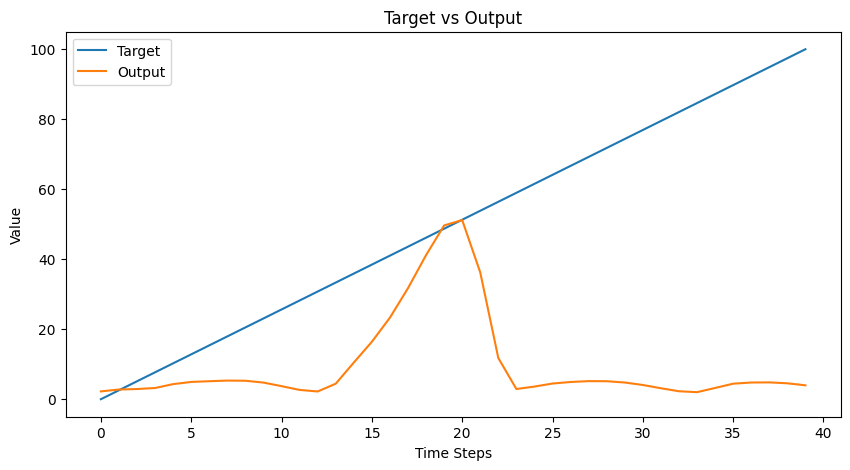

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(x, target, label='Target')
plt.plot(x, final_output, label='Output')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Target vs Output')
plt.legend()
plt.show()

# Training the RBF for an entire target


In [12]:
# Define the target
df = pd.read_csv("input_cut_downsampled.csv")
target = df["jointFR1"].values
# print(target.shape[0], target)

# Initialize the weights
W = np.ones(n_kernels)

# Initialize the output
outputs = []
output = 0

# Training the weights (delta_w = lr*(target - output)*input)
lr = 0.01
delta_w = 0
err_threshold = 0
epochs = 10000

# For a certain amount of epochs
for t in range(epochs):
    err_threshold=0 # every epoch, reset the error threshold
    if t%1000 == 0: # print the epoch number every 1000 epochs
        print(t)
# Calculate the output of the RBF layer 
# by iterating through the positions of the kernels
# k = index, means_kern_pos[k] = value
    for k,mean_pos in enumerate(means_kern_pos):
        output = 0
#Cycle through the kernels calculating the output of every kernel
        for i in range(n_kernels):
            output += kernels[i][mean_pos] * W[i]
# Calculate the error at the current index based on the calculated output
        error = target[mean_pos] - output
        delta_w = lr * error 
# Update the weights based on the error
        W[k] = W[k] + delta_w
# Check for the error threshold, using abs to check the surronding of the target
        if abs(error) > err_threshold:
            err_threshold = abs(error)
    if err_threshold < 0.01:
        break
    

final_output = []
print(W.shape)
# See training results
for j in range(num_steps):
    output = 0
    for i in range(n_kernels):
        output += kernels[i][j] * W[i]
    final_output.append(output)

# Convert the final_output list to a DataFrame
df_final_output = pd.DataFrame({'final_output': final_output})

# Save the DataFrame as a CSV file
df_final_output.to_csv('final_output.csv', index=False)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
(40,)


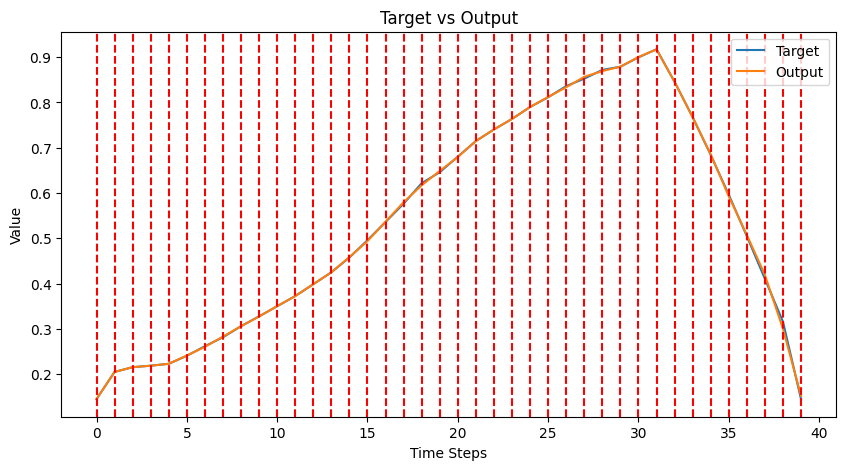

In [13]:
# Read the CSV file
#df = pd.read_csv('final_output_10000.csv')
df_1 = pd.read_csv('final_output.csv')

plt.figure(figsize=(10, 5))
plt.plot(x, target, label='Target')
plt.plot(x, df_1["final_output"], label='Output')
# Plot vertical lines at every step
for step in x:
    plt.axvline(x=step, color='r', linestyle='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data from CSV')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Target vs Output')
plt.legend()
plt.show()

In [41]:
# Define the target
df = pd.read_csv("input_cut_downsampled.csv")

# Initialize the weights
W = np.ones(n_kernels)
lr = 0.01
delta_w = 0
err_threshold = 0
epochs = 10000

# Initialize the output
outputs = []
output = 0
final_output = []

# Initialize the output DataFrame
output_predictions_df = pd.DataFrame()
W_trained_df = pd.DataFrame()

final_weights = []
for column in df.columns:
#Skip object type columns    
    if df[column].dtype != 'object': 
        target = df[column].values
        print(column)
# For a certain amount of epochs
    for t in range(epochs):
        err_threshold=0 # every epoch, reset the error threshold
        if t%1000 == 0: # print the epoch number every 1000 epochs
            print(t)
# Calculate the output of the RBF layer 
# by iterating through the positions of the kernels
# k = index, means_kern_pos[k] = value
        for k,mean_pos in enumerate(means_kern_pos):
            output = 0
#Cycle through the kernels calculating the output of every kernel
            for i in range(n_kernels):
                output += kernels[i][mean_pos] * W[i]
# Calculate the error at the current index based on the calculated output
            error = target[mean_pos] - output
            delta_w = lr * error 
# Update the weights based on the error
            W[k] = W[k] + delta_w
# Check for the error threshold, using abs to check the surronding of the target
            if abs(error) > err_threshold:
                err_threshold = abs(error)
        if err_threshold < 0.01:
            break
# Append the trained weights to the trained_weights_df
    W_trained_df[column] = W.tolist()
# See training results
    final_output = []
    for j in range(num_steps):
        output = 0
        for i in range(n_kernels):
            output += kernels[i][j] * W[i]
# Append the output to the final_output list
        final_output.append(output)
        
    
# Convert the final_output list to a DataFrame
    output_predictions_df[column] = final_output
    
output_predictions_df.to_csv("output_predictions.csv", index=False)
W_trained_df.to_csv("trained weights.csv", index=False)


jointFR1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointFR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointFR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footFRx
0
1000
2000
3000
4000
footFRz
0
1000
2000
3000
4000
5000
6000
7000
jointMR1
0
1000
2000
3000
jointMR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointMR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footMRx
0
1000
2000
3000
4000
5000
6000
7000
8000
footMRz
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR1
0
1000
2000
3000
4000
5000
6000
7000
jointHR2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
jointHR3
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
footHRx
0
1000
2000
3000
footHRz
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [37]:
print(W.tolist())
print(W)

print(final_output)



[0.45229783560960324, -0.19429110581556755, 0.25344072367335224, 0.19174405611386247, -0.021437058210350763, 0.31948508879299814, -0.12665157004398572, 0.03932167096818084, 0.3169333036396396, -0.1783799579600866, 0.32437717660319954, 0.17901305051327146, 0.2860474756147089, 0.3377574329309362, -0.18117955116987328, 0.8009090701417892, -0.38395172727564847, -0.05220661814042788, 0.3484942978959799, -0.017099893623060587, 0.17137499165940828, 0.17658647275804581, 0.2308742850721522, 0.28669899047130587, 0.006330631024514117, 0.5556312580498753, -0.4494221453924256, -0.22014374123593072, 1.3126448348235755, -1.308984943310353, 0.8869854417506554, -0.12567199277608662, 0.2447630833133721, 0.2597463290937802, -0.007068133135466319, 0.6493829786208394, -0.2592098773398183, -1.139750165651031, 1.6677259751553257, -0.37126443335608955]
[ 0.45229784 -0.19429111  0.25344072  0.19174406 -0.02143706  0.31948509
 -0.12665157  0.03932167  0.3169333  -0.17837996  0.32437718  0.17901305
  0.28604748 

In [19]:
# Define the target
df = pd.read_csv("input_cut_downsampled.csv")

# Initialize the weights
W = np.ones(n_kernels)
lr = 0.01
delta_w = 0
err_threshold = 0
epochs = 10000

# Iterate over each column (target variable)
for column in df.columns:
    if df[column].dtype != 'object':  # Skip object type columns
        target = df[column].values
        
        # Train the RBF network
        for t in range(epochs):
            err_threshold = 0  # Reset the error threshold for each epoch
            if t % 1000 == 0:  # Print the epoch number every 1000 epochs
                print(t)
            
            # Calculate the output of the RBF layer for each kernel
            for k, mean_pos in enumerate(means_kern_pos):
                output = 0
                # Cycle through the kernels and calculate the output of each kernel
                for i in range(n_kernels):
                    output += kernels[i][mean_pos] * W[i]
                # Calculate the error at the current index based on the calculated output
                error = target[mean_pos] - output
                delta_w = lr * error
                # Update the weights based on the error
                W[k] = W[k] + delta_w
                # Update the error threshold
                if abs(error) > err_threshold:
                    err_threshold = abs(error)
            # Check if the error threshold is below the specified threshold
            if err_threshold < 0.01:
                break
        
        # Generate final predictions
        final_output = [0] * num_steps
        for j in range(num_steps):
            output = 0
            for i in range(n_kernels):
                output += kernels[i][j] * W[i]
            final_output.append(output)
        
        # Append predictions to the next column in the CSV file
        df[column + '_prediction'] = final_output

# Save the DataFrame with predictions to a CSV file
df.to_csv("output_predictions.csv", index=False)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


ValueError: Length of values (80) does not match length of index (40)